# Simplex Algorithm - Maximization

This notebook implements the simplex algorithm to maximize the objective function using vertex marching approach.

## Assumptions
1. Initial feasible point is provided

## Import Libraries

In [1]:
import csv
import numpy as np
import sympy as sp
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich import box
import matplotlib.pyplot as plt

console = Console()

## Read Input Data from CSV

The CSV file format:
- First row: Initial feasible point `z` (excluding last element)
- Second row: Cost vector `c` (excluding last element)
- Last column: Constraint vector `b` (from row 3 onwards)
- Remaining data: Constraint matrix `A`

In [2]:
filename = 'testcase_1.csv'

with open(filename, newline='') as csvfile:
    reader = csv.reader(csvfile)
    data = list(reader)

z = np.array([float(val) for val in data[0][:-1]])
c = np.array([float(val) for val in data[1][:-1]])
b = np.array([float(row[-1]) for row in data[2:]])
A = np.array([[float(val) for val in row[:-1]] for row in data[2:]])

m, n = len(b), len(c)

## Display Input Data

In [3]:
console.print("[bold yellow]           SIMPLEX ALGORITHM - INPUT DATA[/bold yellow]\n")

input_table = Table(show_header=True, header_style="bold magenta", box=box.ROUNDED)
input_table.add_column("Parameter", style="cyan", width=30)
input_table.add_column("Value", style="green")

input_table.add_row("Initial Feasible Point (z)", str(z))
input_table.add_row("Cost Vector (c)", str(c))
input_table.add_row("Constraint Vector (b)", str(b))
input_table.add_row("Matrix A", str(A))
input_table.add_row("Dimensions (m × n)", f"{m} × {n}")

console.print(input_table)
console.print()

           SIMPLEX ALGORITHM - INPUT DATA

╭────────────────────────────────┬─────────────╮
│ Parameter                      │ Value       │
├────────────────────────────────┼─────────────┤
│ Initial Feasible Point (z)     │ [0. 0.]     │
│ Cost Vector (c)                │ [5. 2.]     │
│ Constraint Vector (b)          │ [1. 1. 1.]  │
│ Matrix A                       │ [[ 0.  1.]  │
│                                │  [ 1.  0.]  │
│                                │  [-1. -1.]] │
│ Dimensions (m × n)             │ 3 × 2       │
╰────────────────────────────────┴─────────────╯

## Phase 1: Move from Feasible Point to Vertex

In this phase, we move from the initial feasible point to a vertex of the polytope. A point is a vertex if the rank of tight constraints equals n (number of variables).

In [4]:
console.print("[bold yellow]        PHASE 1: Feasible Point to Vertex[/bold yellow]\n")

track_cost = [np.dot(c, z)]
track_vertices = [z]

# Identify tight constraints
product = np.dot(A, z)
mask = np.abs(product - b) < 1e-8
tight_rows = A[mask]
untight_rows = A[~mask]
rank = np.linalg.matrix_rank(tight_rows) if len(tight_rows) > 0 else 0

if rank == n:
    console.print(Panel("[bold green]Already at a vertex![/bold green]", border_style="green", box=box.DOUBLE))
    z_new = z
else:
    console.print("[bold yellow]Not at a vertex. Searching for a vertex...[/bold yellow]\n")
    z_old = z
    z_new = z
    iteration = 0
    
    while rank != n:
        iteration += 1
        console.print(f"[cyan]Iteration {iteration}[/cyan] | [magenta]Rank: {rank}[/magenta]")
        
        # Find direction to move
        if len(tight_rows) == 0:
            u = np.random.rand(untight_rows.shape[-1])
        else:
            null_space_vectors = sp.Matrix(tight_rows).nullspace()
            u = np.array(null_space_vectors[0]).astype(float).flatten()
        
        # Calculate step size
        while True:
            alphas = [(b_i - np.dot(a2_i, z_old)) / np.dot(a2_i, u) 
                     for b_i, a2_i in zip(b[~mask], untight_rows)]
            positive_alphas = [alpha for alpha in alphas if alpha > 0]
            if len(positive_alphas) == 0:
                u = -u
            else:
                break
        
        alpha = min(positive_alphas)
        z_new = z_old + alpha * u
        
        # Update tight constraints
        product = np.dot(A, z_new)
        mask = np.abs(product - b) < 1e-8
        tight_rows = A[mask]
        untight_rows = A[~mask]
        z_old = z_new
        rank = np.linalg.matrix_rank(tight_rows) if len(tight_rows) > 0 else 0
        
        track_cost.append(np.dot(c, z_new))
        track_vertices.append(z_new)
    
    console.print(f"\n[bold green]Vertex found! | Rank: {rank}[/bold green]")

z = z_new

        PHASE 1: Feasible Point to Vertex

Not at a vertex. Searching for a vertex...

Iteration 1 | Rank: 0

Iteration 2 | Rank: 1

Vertex found! | Rank: 2

### Visualize Phase 1 Progress

Phase 1: Cost Progression

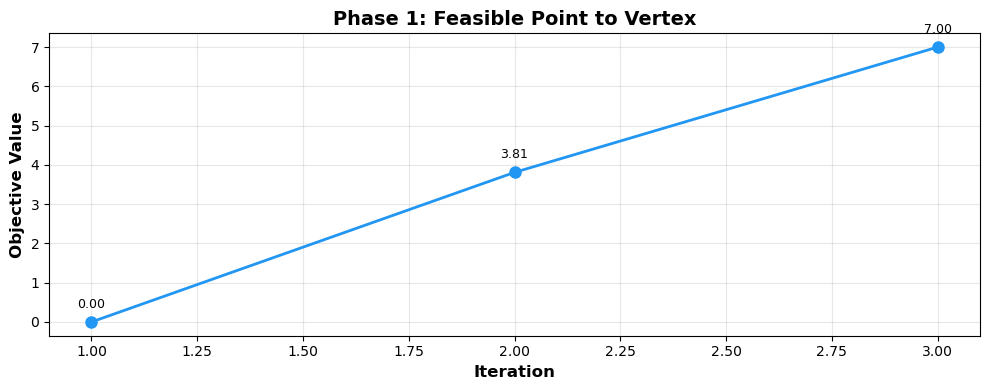

Phase 1 visualization complete!

In [5]:
console.print("\n[bold cyan]Phase 1: Cost Progression[/bold cyan]")
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(range(1, len(track_cost) + 1), track_cost, 
        marker='o', linewidth=2, markersize=8, color='#2196F3')
ax.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax.set_ylabel('Objective Value', fontsize=12, fontweight='bold')
ax.set_title('Phase 1: Feasible Point to Vertex', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
for i, cost in enumerate(track_cost):
    ax.annotate(f'{cost:.2f}', (i+1, cost), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9)
plt.tight_layout()
plt.show()
console.print("[green]Phase 1 visualization complete![/green]\n")

### Display Initial Vertex

In [6]:
console.print("\n[bold]Initial Vertex:[/bold]", style="yellow")
console.print(Panel(str(z), border_style="yellow", box=box.ROUNDED))
console.print()

Initial Vertex:

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ [1. 1.]                                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## Phase 2: Vertex Marching to Optimal Vertex

In this phase, we move from vertex to vertex along edges of the polytope that improve the objective function until we reach the optimal vertex.

In [7]:
console.print("[bold yellow]       PHASE 2: Vertex to Optimal Vertex[/bold yellow]\n")

iteration = 0
z_optimal = None
phase2_start_cost = np.dot(c, z)
phase2_costs = [phase2_start_cost]
phase2_vertices = [z]

while True:
    iteration += 1
    console.print(f"[cyan]Iteration {iteration}[/cyan]")
    
    # Identify tight constraints at current vertex
    product = np.dot(A, z)
    mask = np.abs(product - b) < 1e-8
    tight_rows = A[mask]
    untight_rows = A[~mask]
    
    # Calculate directions to adjacent vertices
    try:
        directions = (-np.linalg.inv(tight_rows)).T
    except np.linalg.LinAlgError:
        console.print(Panel("[bold red]Matrix is singular. Cannot compute the inverse.[/bold red]", border_style="red", box=box.DOUBLE))
        z_optimal = None
        break
    
    # Filter directions that improve objective
    positive_directions = [d for d in directions if np.dot(d, c) > 0]
    
    if not positive_directions:
        console.print(Panel("[bold green]Reached the optimal vertex![/bold green]", border_style="green", box=box.DOUBLE))
        z_optimal = z
        break
    
    u = positive_directions[0]
    
    # Calculate step size to next vertex
    alphas = [(b_i - np.dot(a2_i, z)) / np.dot(a2_i, u) 
             for b_i, a2_i in zip(b[~mask], untight_rows)]
    positive_alphas = [alpha for alpha in alphas if alpha > 0]
    
    if len(positive_alphas) == 0:
        console.print(Panel("[bold red]The problem is unbounded. Can't find an optimal solution![/bold red]", border_style="red", box=box.DOUBLE))
        z_optimal = None
        break
    
    console.print(f"  [dim]Positive alphas count: {len(positive_alphas)}[/dim]")
    alpha = min(positive_alphas)
    z = z + alpha * u
    
    phase2_costs.append(np.dot(c, z))
    phase2_vertices.append(z)
    track_cost.append(np.dot(c, z))
    track_vertices.append(z)

       PHASE 2: Vertex to Optimal Vertex

Iteration 1

╔═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║ Reached the optimal vertex!                                                                                     ║
╚═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝

### Visualize Phase 2 Progress

Phase 2: Cost Progression

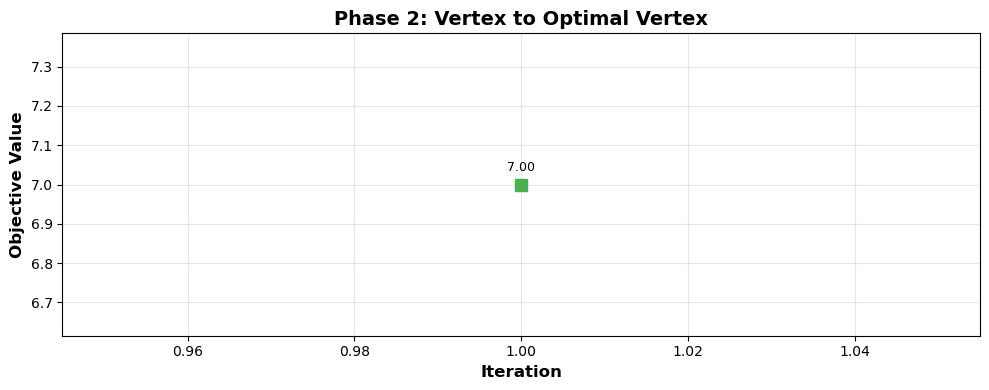

Phase 2 visualization complete!

In [8]:
console.print("\n[bold cyan]Phase 2: Cost Progression[/bold cyan]")
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(range(1, len(phase2_costs) + 1), phase2_costs, 
        marker='s', linewidth=2, markersize=8, color='#4CAF50')
ax.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax.set_ylabel('Objective Value', fontsize=12, fontweight='bold')
ax.set_title('Phase 2: Vertex to Optimal Vertex', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
for i, cost in enumerate(phase2_costs):
    ax.annotate(f'{cost:.2f}', (i+1, cost), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9)
plt.tight_layout()
plt.show()
console.print("[green]Phase 2 visualization complete![/green]\n")

### Combined Visualization (Both Phases)

Combined Visualization (Both Phases)

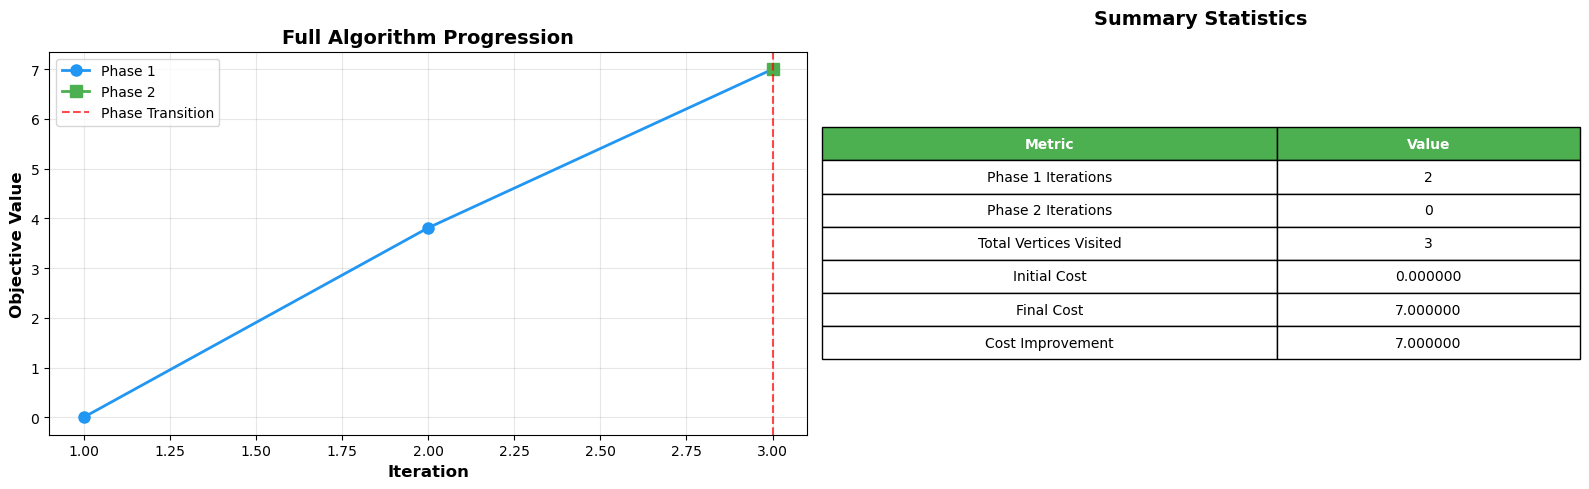

Combined visualization complete!

In [9]:
console.print("\n[bold cyan]Combined Visualization (Both Phases)[/bold cyan]")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Left plot: Combined progression
phase1_len = len(track_cost) - len(phase2_costs) + 1
ax1.plot(range(1, phase1_len + 1), track_cost[:phase1_len], 
         marker='o', linewidth=2, markersize=8, color='#2196F3', label='Phase 1')
phase2_x = range(phase1_len, len(track_cost) + 1)
ax1.plot(phase2_x, track_cost[phase1_len-1:], 
         marker='s', linewidth=2, markersize=8, color='#4CAF50', label='Phase 2')
ax1.axvline(x=phase1_len, color='red', linestyle='--', alpha=0.7, label='Phase Transition')
ax1.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax1.set_ylabel('Objective Value', fontsize=12, fontweight='bold')
ax1.set_title('Full Algorithm Progression', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right plot: Summary statistics table
ax2.axis('tight')
ax2.axis('off')
summary_data = [
    ['Phase 1 Iterations', str(phase1_len - 1)],
    ['Phase 2 Iterations', str(len(phase2_costs) - 1)],
    ['Total Vertices Visited', str(len(track_vertices))],
    ['Initial Cost', f'{track_cost[0]:.6f}'],
    ['Final Cost', f'{track_cost[-1]:.6f}'],
    ['Cost Improvement', f'{track_cost[-1] - track_cost[0]:.6f}']
]
table = ax2.table(cellText=summary_data, colLabels=['Metric', 'Value'],
                  cellLoc='center', loc='center', colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
for i in range(2):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')
ax2.set_title('Summary Statistics', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()
console.print("[green]Combined visualization complete![/green]\n")

## Summary Results

In [10]:
console.print("[bold yellow]                    SUMMARY[/bold yellow]\n")

summary_table = Table(show_header=True, header_style="bold magenta", box=box.DOUBLE)
summary_table.add_column("Metric", style="cyan", width=35)
summary_table.add_column("Value", style="green", width=30)

if z_optimal is not None:
    summary_table.add_row("Total vertices visited", str(len(track_vertices)))
    summary_table.add_row("Optimal objective value", f"{track_cost[-1]:.6f}")
    summary_table.add_row("Optimal solution", str(z_optimal))
    console.print(summary_table)
    console.print()
    console.print(Panel(f"[bold green]Optimal Vertex:[/bold green]\n{z_optimal}", border_style="green", box=box.ROUNDED))
    console.print(f"\n[bold]Optimal Cost:[/bold] [green]{track_cost[-1]:.6f}[/green]")
else:
    summary_table.add_row("Status", "Problem is unbounded!")
    console.print(summary_table)
    console.print()
    console.print(Panel("[bold red]Problem is unbounded![/bold red]", border_style="red", box=box.DOUBLE))

                    SUMMARY

╔═════════════════════════════════════╦════════════════════════════════╗
║ Metric                              ║ Value                          ║
╠═════════════════════════════════════╬════════════════════════════════╣
║ Total vertices visited              ║ 3                              ║
║ Optimal objective value             ║ 7.000000                       ║
║ Optimal solution                    ║ [1. 1.]                        ║
╚═════════════════════════════════════╩════════════════════════════════╝

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Optimal Vertex:                                                                                                 │
│ [1. 1.]                                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Optimal Cost: 7.000000

## Sequence of Vertices Visited

In [11]:
console.print("\n[bold]Sequence of vertices visited:[/bold]")
vertices_table = Table(show_header=True, header_style="bold cyan", box=box.ROUNDED)
vertices_table.add_column("Vertex #", style="cyan", width=12)
vertices_table.add_column("Coordinates", style="yellow", width=50)
vertices_table.add_column("Cost", style="green", width=15)

for i, (vertex, cost) in enumerate(zip(track_vertices, track_cost), 1):
    vertices_table.add_row(str(i), str(vertex), f"{cost:.6f}")

console.print(vertices_table)
console.print("\n[bold green]Simplex algorithm completed successfully![/bold green]\n")

Sequence of vertices visited:

╭──────────────┬────────────────────────────────────────────────────┬─────────────────╮
│ Vertex #     │ Coordinates                                        │ Cost            │
├──────────────┼────────────────────────────────────────────────────┼─────────────────┤
│ 1            │ [0. 0.]                                            │ 0.000000        │
│ 2            │ [0.36196051 1.        ]                            │ 3.809803        │
│ 3            │ [1. 1.]                                            │ 7.000000        │
╰──────────────┴────────────────────────────────────────────────────┴─────────────────╯

Simplex algorithm completed successfully!